In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pickle
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from utils import *
import warnings
import xgboost as xgb

# Suppress warnings and set display options
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 300

c:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
c:\Users\aless\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cpu


In [4]:
train = pd.read_parquet('data/train.parquet')
val = pd.read_parquet('data/val.parquet')
test = pd.read_parquet('data/test.parquet')

In [5]:
def rmspe_loss(y_true, y_pred):
    if isinstance(y_true, np.ndarray):
        y_true = torch.tensor(y_true, dtype=torch.float32)
    if isinstance(y_pred, np.ndarray):
        y_pred = torch.tensor(y_pred, dtype=torch.float32)
    return torch.sqrt(torch.mean(((y_true - y_pred) / y_true) ** 2))

def calculate_r_squared(y_true, y_pred):
    y_true = torch.tensor(y_true,dtype=torch.float32)
    y_pred = torch.tensor(y_pred,dtype=torch.float32)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared.item()

# LSTM

In [64]:
remove_price = False
if remove_price:
    train_data, val_data, test_data = remove_price_col(train, val, test)
else:
    train_data = train
    val_data = val
    test_data = test

In [65]:
scaler = StandardScaler()
torch_tensor=True
X_train, y_train = createX_and_y(train_data,scaler,torch_tensor)
X_val, y_val = createX_and_y(val_data,scaler,torch_tensor)
X_test, y_test = createX_and_y(test_data,scaler,torch_tensor)


In [71]:
colnames  = train_data.drop(columns='target').columns

## Activation = Tanh

In [66]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        # Adjust the output size of fc1 to hidden_size
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Tanh()
        # Adjust the input size of fc3 to hidden_size // 2
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out


# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 96
num_layers = 1
output_size = 1
num_epochs = 20
learning_rate = 0.001

# Create model, loss function, optimizer, and scheduler
model = LSTMNet(input_size, hidden_size, num_layers, output_size).to(device)
criterion = rmspe_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Prepare data for LSTM (assuming time series data)
# In this case, we'll treat each sample as a sequence with length 1
X_train_tensor = X_train.unsqueeze(1)
X_val_tensor = X_val.unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(targets.view(-1, 1), outputs)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor.to(device)).squeeze()
        print(torch.mean(train_predictions))
        train_rmspe = rmspe_loss(y_train.to(device), train_predictions).item()
    
    with torch.no_grad():
        val_predictions = model(X_val_tensor.to(device)).squeeze()
        print(torch.mean(val_predictions))
        val_loss = criterion(y_val.to(device), val_predictions).item()
        val_rmspe = val_loss  # Since val_loss is already RMSPE
    
    # Step the scheduler
    scheduler.step()
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.9f}, Train RMSPE: {train_rmspe:.4f}, Val Loss: {val_loss:.9f}, Val RMSPE: {val_rmspe:.4f}')


tensor(0.0027)
tensor(0.0027)
Epoch 1, Train Loss: 0.701739095, Train RMSPE: 0.4028, Val Loss: 0.402439833, Val RMSPE: 0.4024
tensor(0.0040)
tensor(0.0040)
Epoch 2, Train Loss: 0.374533598, Train RMSPE: 0.3707, Val Loss: 0.366031528, Val RMSPE: 0.3660
tensor(0.0038)
tensor(0.0039)
Epoch 3, Train Loss: 0.345403688, Train RMSPE: 0.2957, Val Loss: 0.296445698, Val RMSPE: 0.2964
tensor(0.0036)
tensor(0.0036)
Epoch 4, Train Loss: 0.327998066, Train RMSPE: 0.2898, Val Loss: 0.288543552, Val RMSPE: 0.2885
tensor(0.0038)
tensor(0.0038)
Epoch 5, Train Loss: 0.315466317, Train RMSPE: 0.3231, Val Loss: 0.315518886, Val RMSPE: 0.3155
tensor(0.0036)
tensor(0.0036)
Epoch 6, Train Loss: 0.307596431, Train RMSPE: 0.2687, Val Loss: 0.270835370, Val RMSPE: 0.2708
tensor(0.0034)
tensor(0.0034)
Epoch 7, Train Loss: 0.305373504, Train RMSPE: 0.2654, Val Loss: 0.265437335, Val RMSPE: 0.2654
tensor(0.0031)
tensor(0.0031)
Epoch 8, Train Loss: 0.299469517, Train RMSPE: 0.2971, Val Loss: 0.301504314, Val RMSPE:

In [67]:
with torch.no_grad():
    # Evaluate on validation data
    val_predictions = model(X_val_tensor.to(device)).squeeze()
    rmspe_val = criterion(y_val.to(device), val_predictions).item()
    r_squared_val = calculate_r_squared(y_val.to(device), val_predictions)
    
    # Evaluate on test data
    X_test_tensor = X_test.unsqueeze(1).to(device)  # Assuming X_test is similar to X_train and X_val
    test_predictions = model(X_test_tensor).squeeze()
    rmspe_test = criterion(y_test.to(device), test_predictions).item()
    r_squared_test = calculate_r_squared(y_test.to(device), test_predictions)

    print(f"Validation RMSPE: {rmspe_val}")
    print(f"Validation R-squared: {r_squared_val}")
    print(f"Test RMSPE: {rmspe_test}")
    print(f"Test R-squared: {r_squared_test}")

Validation RMSPE: 0.247860386967659
Validation R-squared: 0.7591353058815002
Test RMSPE: 0.24471266567707062
Test R-squared: 0.7639983892440796


In [68]:
input_size = X_test.shape[1] if X_test.dim() == 2 else X_test.shape[2]
X_test_tensor = X_test if X_test.dim() == 3 else X_test.unsqueeze(1)
importances = permutation_importance_LSTM(model, X_test_tensor, y_test, rmspe)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

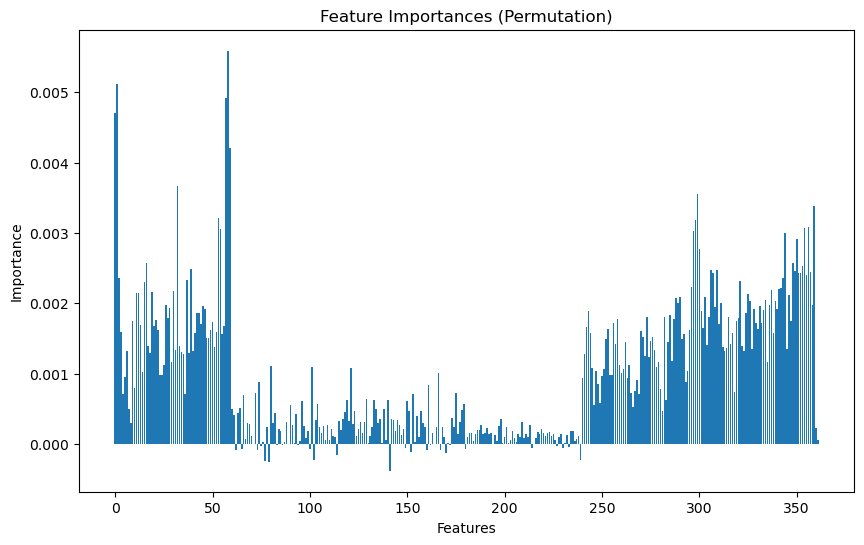

In [69]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Permutation)')
plt.show()

In [72]:
df = pd.DataFrame({'Feature': colnames, 'Importance': abs(importances)})
df = df.sort_values(by='Importance', ascending=False)

In [73]:
sum_dict = {}

# Loop through dataframe to populate sum_dict
for index, row in df.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    initial_chars = feature[:5]
    if initial_chars not in sum_dict:
        sum_dict[initial_chars] = importance
    else:
        sum_dict[initial_chars] += importance

# Renaming keys in sum_dict
sum_dict['ask1_bid1_spread'] = sum_dict.pop('ask1_')
sum_dict['wap2_log_high_low'] = sum_dict.pop('wap2_')
sum_dict['wap1_log_high_low'] = sum_dict.pop('wap1_')

# Sorting the summed dictionary
sorted_sumd = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)

# Separating keys and values for plotting
keys = [item[0] for item in sorted_sumd]
values = [item[1] for item in sorted_sumd]

In [74]:
values = [round(x / sum(values),3) for x in values]

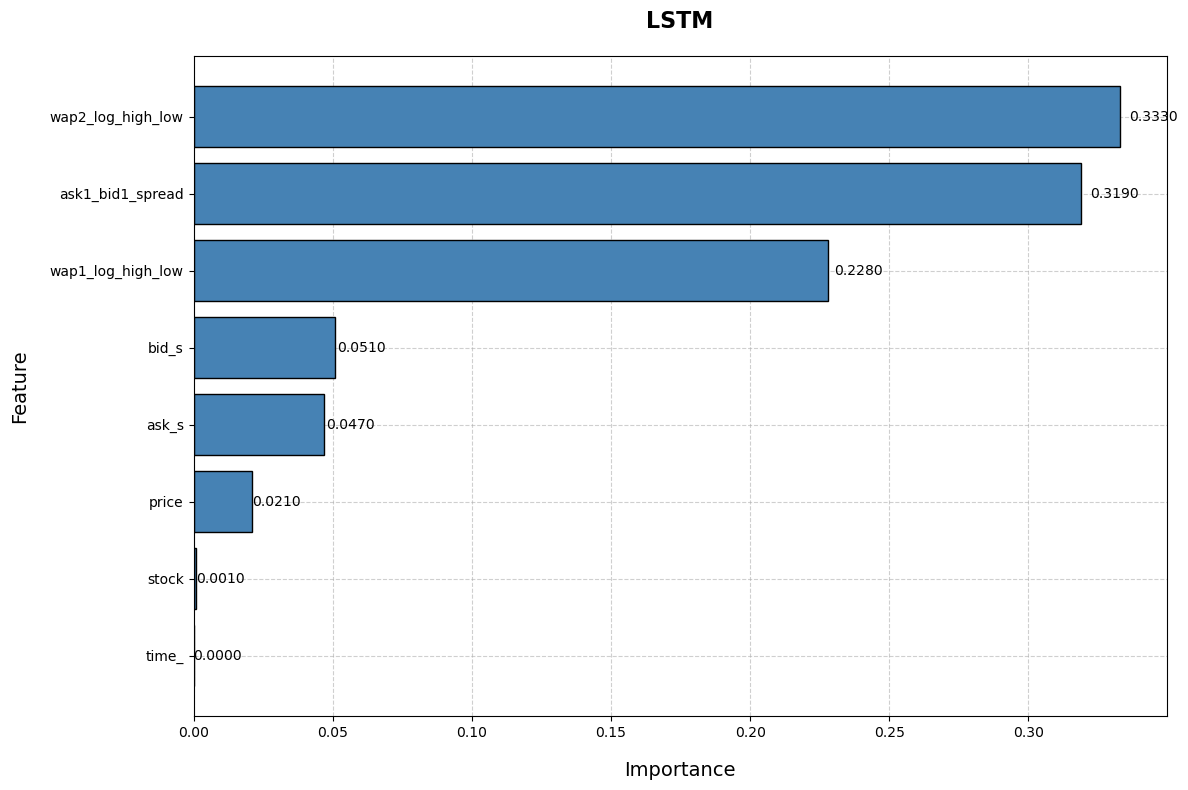

In [75]:
# Plot the feature importances
plot_feature_importances(values, keys, 'LSTM')

## Activation Sigmoid

In [15]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        # Adjust the output size of fc1 to hidden_size
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Sigmoid()
        # Adjust the input size of fc3 to hidden_size // 2
        self.fc3 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 1
output_size = 1
num_epochs = 20
learning_rate = 0.001

# Create model, loss function, optimizer, and scheduler
model = LSTMNet(input_size, hidden_size, num_layers, output_size).to(device)
criterion = rmspe_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Prepare data for LSTM (assuming time series data)
# In this case, we'll treat each sample as a sequence with length 1
X_train_tensor = X_train.unsqueeze(1)
X_val_tensor = X_val.unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(targets.view(-1, 1), outputs)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor.to(device)).squeeze()
        print(torch.mean(train_predictions))
        train_rmspe = rmspe_loss(y_train.to(device), train_predictions).item()
    
    with torch.no_grad():
        val_predictions = model(X_val_tensor.to(device)).squeeze()
        print(torch.mean(val_predictions))
        val_loss = criterion(y_val.to(device), val_predictions).item()
        val_rmspe = val_loss  # Since val_loss is already RMSPE
    
    # Step the scheduler
    scheduler.step()
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.9f}, Train RMSPE: {train_rmspe:.4f}, Val Loss: {val_loss:.9f}, Val RMSPE: {val_rmspe:.4f}')


tensor(0.0074)
tensor(0.0074)
Epoch 1, Train Loss: 0.864523539, Train RMSPE: 1.9016, Val Loss: 1.877275825, Val RMSPE: 1.8773
tensor(0.0041)
tensor(0.0041)
Epoch 2, Train Loss: 0.669443828, Train RMSPE: 0.5416, Val Loss: 0.531675577, Val RMSPE: 0.5317
tensor(0.0061)
tensor(0.0061)
Epoch 3, Train Loss: 0.656657901, Train RMSPE: 1.3443, Val Loss: 1.325960875, Val RMSPE: 1.3260
tensor(0.0037)
tensor(0.0037)
Epoch 4, Train Loss: 0.649771062, Train RMSPE: 0.4513, Val Loss: 0.440728068, Val RMSPE: 0.4407
tensor(0.0035)
tensor(0.0035)
Epoch 5, Train Loss: 0.646331968, Train RMSPE: 0.2720, Val Loss: 0.272663355, Val RMSPE: 0.2727
tensor(0.0034)
tensor(0.0034)
Epoch 6, Train Loss: 0.664422338, Train RMSPE: 0.2954, Val Loss: 0.294306636, Val RMSPE: 0.2943
tensor(0.0012)
tensor(0.0012)
Epoch 7, Train Loss: 0.627474378, Train RMSPE: 1.0619, Val Loss: 1.056213975, Val RMSPE: 1.0562
tensor(0.0025)
tensor(0.0025)
Epoch 8, Train Loss: 0.624306479, Train RMSPE: 0.4816, Val Loss: 0.482155770, Val RMSPE:

In [16]:
with torch.no_grad():
    # Evaluate on validation data
    val_predictions = model(X_val_tensor.to(device)).squeeze()
    rmspe_val = criterion(y_val.to(device), val_predictions).item()
    r_squared_val = calculate_r_squared(y_val.to(device), val_predictions)
    
    # Evaluate on test data
    X_test_tensor = X_test.unsqueeze(1).to(device)  # Assuming X_test is similar to X_train and X_val
    test_predictions = model(X_test_tensor).squeeze()
    rmspe_test = criterion(y_test.to(device), test_predictions).item()
    r_squared_test = calculate_r_squared(y_test.to(device), test_predictions)

    print(f"Validation RMSPE: {rmspe_val}")
    print(f"Validation R-squared: {r_squared_val}")
    print(f"Test RMSPE: {rmspe_test}")
    print(f"Test R-squared: {r_squared_test}")

Validation RMSPE: 0.24247153103351593
Validation R-squared: 0.7526525259017944
Test RMSPE: 0.23913750052452087
Test R-squared: 0.7586371898651123


## No activation

In [17]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 64
num_layers = 1
output_size = 1
num_epochs = 20
learning_rate = 0.001

# Create model, loss function, optimizer, and scheduler
model = LSTMNet(input_size, hidden_size, num_layers, output_size).to(device)
criterion = rmspe_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Prepare data for LSTM (assuming time series data)
# In this case, we'll treat each sample as a sequence with length 1
X_train_tensor = X_train.unsqueeze(1)
X_val_tensor = X_val.unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training the model
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(targets.view(-1, 1), outputs)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train_tensor.to(device)).squeeze()
        print(torch.mean(train_predictions))
        train_rmspe = rmspe_loss(y_train.to(device), train_predictions).item()
    
    with torch.no_grad():
        val_predictions = model(X_val_tensor.to(device)).squeeze()
        print(torch.mean(val_predictions))
        val_loss = criterion(y_val.to(device), val_predictions).item()
        val_rmspe = val_loss  # Since val_loss is already RMSPE
    
    # Step the scheduler
    scheduler.step()
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.9f}, Train RMSPE: {train_rmspe:.4f}, Val Loss: {val_loss:.9f}, Val RMSPE: {val_rmspe:.4f}')

tensor(0.0035)
tensor(0.0035)
Epoch 1, Train Loss: 0.614289599, Train RMSPE: 0.2878, Val Loss: 0.284499198, Val RMSPE: 0.2845
tensor(0.0030)
tensor(0.0030)
Epoch 2, Train Loss: 0.341613756, Train RMSPE: 0.2870, Val Loss: 0.288160801, Val RMSPE: 0.2882
tensor(0.0034)
tensor(0.0034)
Epoch 3, Train Loss: 0.320488607, Train RMSPE: 0.2735, Val Loss: 0.269161433, Val RMSPE: 0.2692
tensor(0.0031)
tensor(0.0031)
Epoch 4, Train Loss: 0.311853884, Train RMSPE: 0.3029, Val Loss: 0.299166888, Val RMSPE: 0.2992
tensor(0.0032)
tensor(0.0032)
Epoch 5, Train Loss: 0.303069751, Train RMSPE: 0.2663, Val Loss: 0.266985357, Val RMSPE: 0.2670
tensor(0.0031)
tensor(0.0031)
Epoch 6, Train Loss: 0.297649626, Train RMSPE: 0.3087, Val Loss: 0.311021507, Val RMSPE: 0.3110
tensor(0.0036)
tensor(0.0036)
Epoch 7, Train Loss: 0.293446093, Train RMSPE: 0.2957, Val Loss: 0.291215658, Val RMSPE: 0.2912
tensor(0.0034)
tensor(0.0034)
Epoch 8, Train Loss: 0.293957228, Train RMSPE: 0.2554, Val Loss: 0.255905598, Val RMSPE:

In [18]:
with torch.no_grad():
    # Evaluate on validation data
    val_predictions = model(X_val_tensor.to(device)).squeeze()
    rmspe_val = criterion(y_val.to(device), val_predictions).item()
    r_squared_val = calculate_r_squared(y_val.to(device), val_predictions)
    
    # Evaluate on test data
    X_test_tensor = X_test.unsqueeze(1).to(device)  # Assuming X_test is similar to X_train and X_val
    test_predictions = model(X_test_tensor).squeeze()
    rmspe_test = criterion(y_test.to(device), test_predictions).item()
    r_squared_test = calculate_r_squared(y_test.to(device), test_predictions)

    print(f"Validation RMSPE: {rmspe_val}")
    print(f"Validation R-squared: {r_squared_val}")
    print(f"Test RMSPE: {rmspe_test}")
    print(f"Test R-squared: {r_squared_test}")

Validation RMSPE: 0.24915151298046112
Validation R-squared: 0.7584447264671326
Test RMSPE: 0.24366427958011627
Test R-squared: 0.7623332142829895


# Lasso

In [24]:
remove_price = True
if remove_price:
    train_data, val_data, test_data = remove_price_col(train, val, test)
else:
    train_data = train
    val_data = val
    test_data = test

In [25]:
scaler = StandardScaler()
torch_tensor=False
X_train, y_train = createX_and_y(train_data,scaler,torch_tensor)
X_val, y_val = createX_and_y(val_data,scaler,torch_tensor)
X_test, y_test = createX_and_y(test_data,scaler,torch_tensor)

In [26]:
colnames  = train_data.drop(columns='target').columns

### Model fitting

In [27]:
lasso = Lasso(alpha=1e-7)
lasso.fit(X_train, y_train)

Lasso(alpha=1e-07)

### Results

In [30]:
rmspe_val = rmspe_loss(y_val, lasso.predict(X_val))
print(f'Validation RMSPE: {rmspe_val:.4f}')
rmspe_test = rmspe_loss(y_test, lasso.predict(X_test))
print(f'Test RMSPE: {rmspe_test:.4f}')
r_squared_val = calculate_r_squared(y_val, lasso.predict(X_val))
print(f'Validation R^2: {r_squared_val:.4f}')
r_squared_test = calculate_r_squared(y_test, lasso.predict(X_test))
print(f'Test R^2: {r_squared_test:.4f}')

Validation RMSPE: 0.3175
Test RMSPE: 0.3079
Validation R^2: 0.7939
Test R^2: 0.7942


In [31]:
# Calculate permutation importances
importances = permutation_importance(lasso, X_test, y_test, metric=rmspe_loss)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

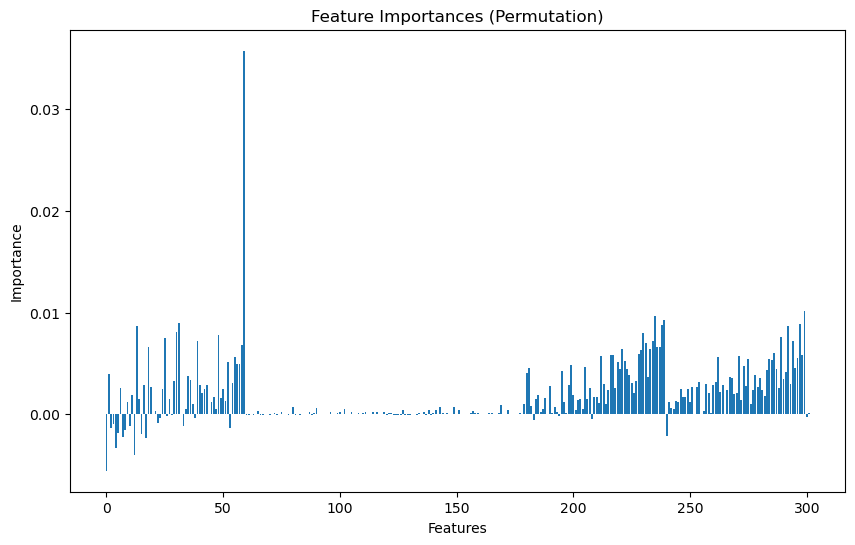

In [32]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Permutation)')
plt.show()

In [33]:
df = pd.DataFrame({'Feature': colnames, 'Importance': abs(importances)})
df = df.sort_values(by='Importance', ascending=False)

In [34]:
sum_dict = {}

# Loop through dataframe to populate sum_dict
for index, row in df.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    initial_chars = feature[:5]
    if initial_chars not in sum_dict:
        sum_dict[initial_chars] = importance
    else:
        sum_dict[initial_chars] += importance

# Renaming keys in sum_dict
sum_dict['ask1_bid1_spread'] = sum_dict.pop('ask1_')
sum_dict['wap2_log_high_low'] = sum_dict.pop('wap2_')
sum_dict['wap1_log_high_low'] = sum_dict.pop('wap1_')

# Sorting the summed dictionary
sorted_sumd = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)

# Separating keys and values for plotting
keys = [item[0] for item in sorted_sumd]
values = [item[1] for item in sorted_sumd]

In [35]:
values = [round(x / sum(values),3) for x in values]

### Feature Importance Plot

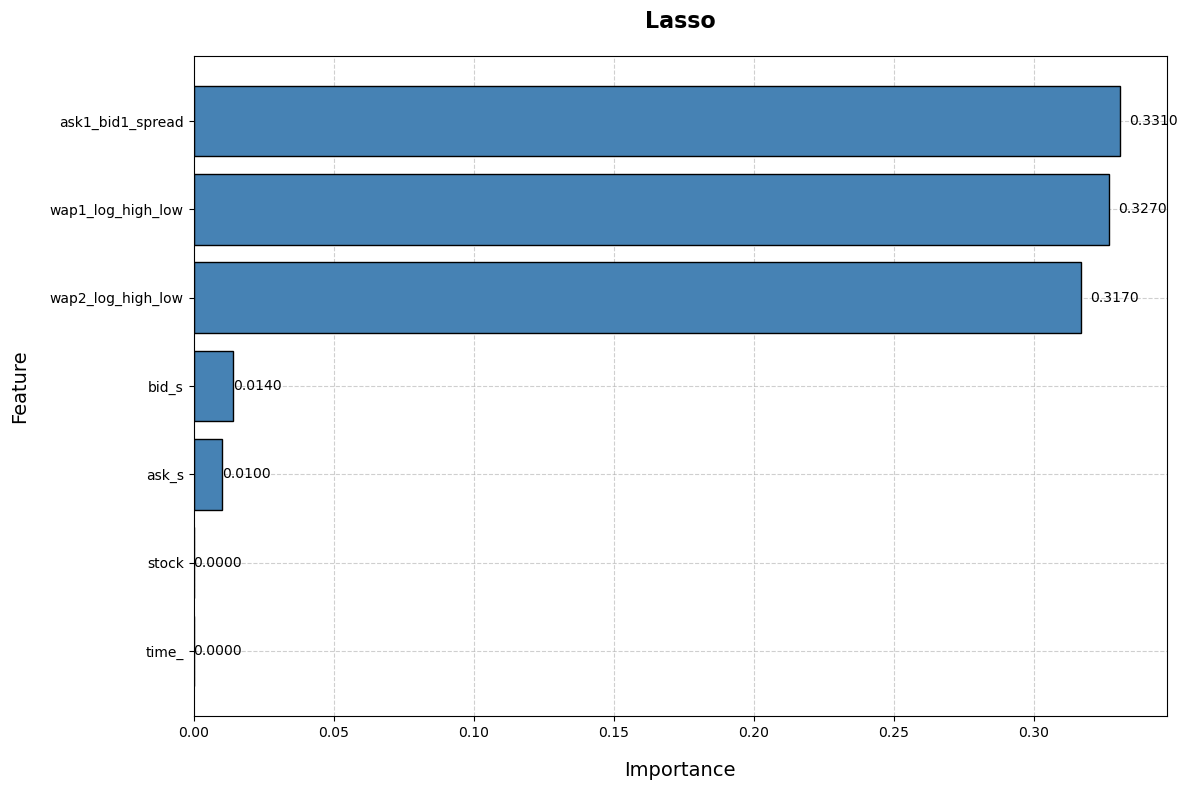

In [41]:
# Plot the feature importances
plot_feature_importances(values, keys, 'Lasso')

# XGBoost

In [51]:
remove_price = False
if remove_price:
    train_data, val_data, test_data = remove_price_col(train, val, test)
else:
    train_data = train
    val_data = val
    test_data = test

In [52]:
cols = train_data.drop(columns='target').columns

In [53]:
scaler = StandardScaler()
torch_tensor=False
X_train, y_train = createX_and_y(train_data,scaler,torch_tensor)
X_val, y_val = createX_and_y(val_data,scaler,torch_tensor)
X_test, y_test = createX_and_y(test_data,scaler,torch_tensor)

cols = train.drop(columns='target').columns

#### Uncomment and run this cell if you want to perform the K-fold cross validation yourself, otherwise the code has already been run, and the results are stored in rmspes10sec_dev_Kfold

In [9]:
# !python XGB_KFOLD.py

In [54]:
with open('rmspes10sec_dev_Kfold', 'rb') as file:
    rmspes = pickle.load(file)
min_value = sorted(rmspes.items(), key=lambda x: x[1])
print(f"Minimum value: {min_value[0]}")

num_boost_round = int(min_value[0][0].split('_')[0])
max_depth = int(min_value[0][0].split('_')[1])
lr = float(min_value[0][0].split('_')[2])

print(f"num_boost_round: {num_boost_round}, max_depth: {max_depth}, lr: {lr}")

Minimum value: ('600_7_0.1', 0.2863471712886934)
num_boost_round: 600, max_depth: 7, lr: 0.1


In [55]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

### Training

In [64]:
params = {"objective" :  "reg:squarederror","tree_method": "hist", "max_depth": max_depth, "learning_rate": lr}

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=num_boost_round,
)

### Validation

In [65]:
y_pred = model.predict(dtest_reg)

rmspe_test = rmspe(y_test, y_pred)

print("RMSPE:", rmspe_test)

RMSPE: 0.25826817312300593


In [72]:
y_pred = model.predict(dtest_reg)
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.8006821386375097


In [67]:
importance = model.get_score(importance_type='gain')

In [68]:
df = pd.DataFrame({'Feature': cols, 'Importance': importance.values()})
df = df.sort_values(by='Importance', ascending=False)

In [69]:
sum_dict = {}

# Loop through dataframe to populate sum_dict
for index, row in df.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    initial_chars = feature[:5]
    if initial_chars not in sum_dict:
        sum_dict[initial_chars] = importance
    else:
        sum_dict[initial_chars] += importance

# Renaming keys in sum_dict
sum_dict['ask1_bid1_spread'] = sum_dict.pop('ask1_')
sum_dict['wap2_log_high_low'] = sum_dict.pop('wap2_')
sum_dict['wap1_log_high_low'] = sum_dict.pop('wap1_')

# Sorting the summed dictionary
sorted_sumd = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)

# Separating keys and values for plotting
keys = [item[0] for item in sorted_sumd]
values = [item[1] for item in sorted_sumd]

In [70]:
values = [round(x / sum(values),3) for x in values]

### Feature Importance Plot

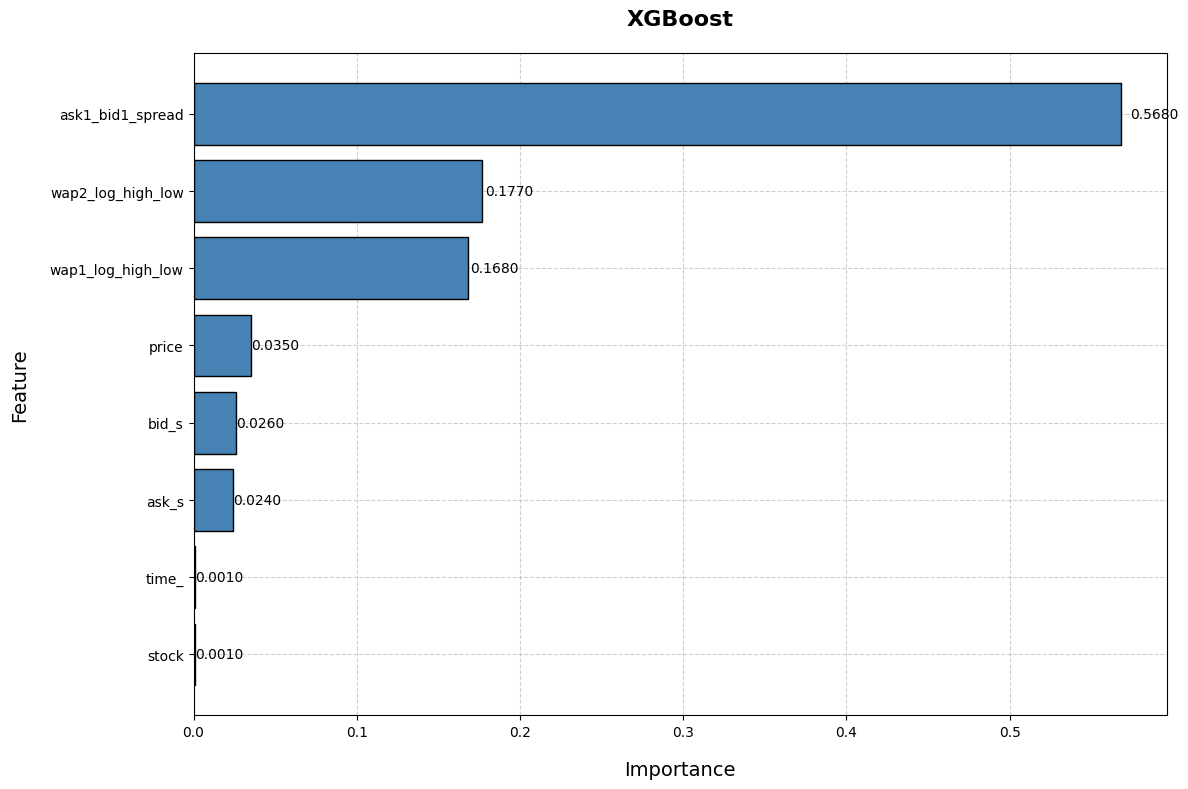

In [71]:
plot_feature_importances(values, keys, 'XGBoost')

# LIGHTGBM

In [6]:
remove_price = False
if remove_price:
    train_data, val_data, test_data = remove_price_col(train, val, test)
else:
    train_data = train
    val_data = val
    test_data = test

In [7]:
scaler = StandardScaler()
torch_tensor=False
X_train, y_train = createX_and_y(train_data,scaler,torch_tensor)
X_val, y_val = createX_and_y(val_data,scaler,torch_tensor)
X_test, y_test = createX_and_y(test_data,scaler,torch_tensor)


In [8]:
colnames  = train_data.drop(columns='target').columns

Run this cell to perform cross validation , othwerwise the code has been run and the parameters found have been used below

In [9]:
def objective(trial, train_data, val_data):
    # Define the hyperparameters to optimize
    params = {
        'objective': 'regression',
        'metric': '',
        'num_leaves': trial.suggest_int('num_leaves', 100, 800),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': 0
    }
    
    # Create the LightGBM datasets
    # train_data = lgb.Dataset(X_train, label=y_train)
    # val_data = lgb.Dataset(X_val, label=y_val)
    
    # Train the LightGBM model
    model = lgb.train(params, train_data, valid_sets=[train_data, val_data])
    
    # Make predictions on the validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    # Calculate the root mean squared error
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    
    return rmse

def objective_cv(trial):
    
    data = pd.concat([train, val])
    X = data.drop(columns='target')
    y = data['target']
    

    fold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []
    for fold_idx, (train_idx, valid_idx) in enumerate(fold.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[valid_idx]
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        rmse = objective(trial, train_data, val_data)
        scores.append(rmse)
    return np.mean(scores)


# Create the study object and optimize the objective function
#study = optuna.create_study(direction='minimize')
#study.optimize(objective_cv, n_trials=30)

# Get the best hyperparameters and the best score
#best_params = study.best_params
#best_score = study.best_value

#p<rint("Best Hyperparameters:", best_params)
#print("Best Score:", best_score)

[I 2024-06-05 14:57:10,413] A new study created in memory with name: no-name-b06b643b-4232-4d48-83a0-04dfbff9c717
[I 2024-06-05 14:58:09,681] Trial 0 finished with value: 0.0013969612401657297 and parameters: {'num_leaves': 203, 'learning_rate': 0.016832240703831877, 'feature_fraction': 0.445732249227185, 'bagging_fraction': 0.4205940289975285, 'bagging_freq': 10}. Best is trial 0 with value: 0.0013969612401657297.
[I 2024-06-05 14:59:51,403] Trial 1 finished with value: 0.0011698238517624726 and parameters: {'num_leaves': 301, 'learning_rate': 0.03731225385075867, 'feature_fraction': 0.9116730857848386, 'bagging_fraction': 0.42973560515360654, 'bagging_freq': 5}. Best is trial 1 with value: 0.0011698238517624726.
[I 2024-06-05 15:01:59,829] Trial 2 finished with value: 0.0011879634832383083 and parameters: {'num_leaves': 625, 'learning_rate': 0.049424612567318914, 'feature_fraction': 0.810523860283884, 'bagging_fraction': 0.15082015766704043, 'bagging_freq': 2}. Best is trial 1 with v

Best Hyperparameters: {'num_leaves': 742, 'learning_rate': 0.09797255020004791, 'feature_fraction': 0.30829625609362304, 'bagging_fraction': 0.9055663124923258, 'bagging_freq': 1}
Best Score: 0.000947291815822455


In [10]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 742,
    'learning_rate': 0.09797255020004791,
    'feature_fraction': 0.30829625609362304,
    'bagging_fraction':  0.9055663124923258, 
    'bagging_freq': 1,
    'verbose': -1 }

train_data = lgb.Dataset(X_train, label=y_train)
light_gbm = lgb.train(params, train_data, num_boost_round=200)


    # Make predictions on the validation set
y_pred = light_gbm.predict(X_val)

rmspe_val = rmspe_loss(y_val, light_gbm.predict(X_val))
print(f'Validation RMSPE: {rmspe_val:.4f}')
rmspe_test = rmspe_loss(y_test, light_gbm.predict(X_test))
print(f'Test RMSPE: {rmspe_test:.4f}')
r_squared_val = calculate_r_squared(y_val, light_gbm.predict(X_val))
print(f'Validation R^2: {r_squared_val:.4f}')
r_squared_test = calculate_r_squared(y_test, light_gbm.predict(X_test))
print(f'Test R^2: {r_squared_test:.4f}')

Validation RMSPE: 0.2888
Test RMSPE: 0.2787
Validation R^2: 0.8036
Test R^2: 0.8099


In [12]:
# Train a LightGBM model
model = lgb.LGBMRegressor(importance_type='gain')
model.fit(X_train, y_train)

# Obtain gain feature importance
gain_importance = model.feature_importances_

# Display feature importance with feature names
feature_names = colnames
gain_importance_df = pd.DataFrame({'Feature': feature_names, 'Gain': gain_importance})
print(gain_importance_df.sort_values(by='Gain', ascending=False))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.452362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77048
[LightGBM] [Info] Number of data points in the train set: 343145, number of used features: 362
[LightGBM] [Info] Start training from score 0.003880
                              Feature      Gain
50   ask1_bid1_spread_avg_50_10s_wide  0.970611
46   ask1_bid1_spread_avg_46_10s_wide  0.853371
28   ask1_bid1_spread_avg_28_10s_wide  0.661670
36   ask1_bid1_spread_avg_36_10s_wide  0.574827
58   ask1_bid1_spread_avg_58_10s_wide  0.485217
..                                ...       ...
203             price_avg_23_10s_wide  0.000000
204             price_avg_24_10s_wide  0.000000
206             price_avg_26_10s_wide  0.000000
208             price_avg_28_10s_wide  0.000000
181              price_avg_1_10s_wide  0.000000

[362 rows x 2 columns]


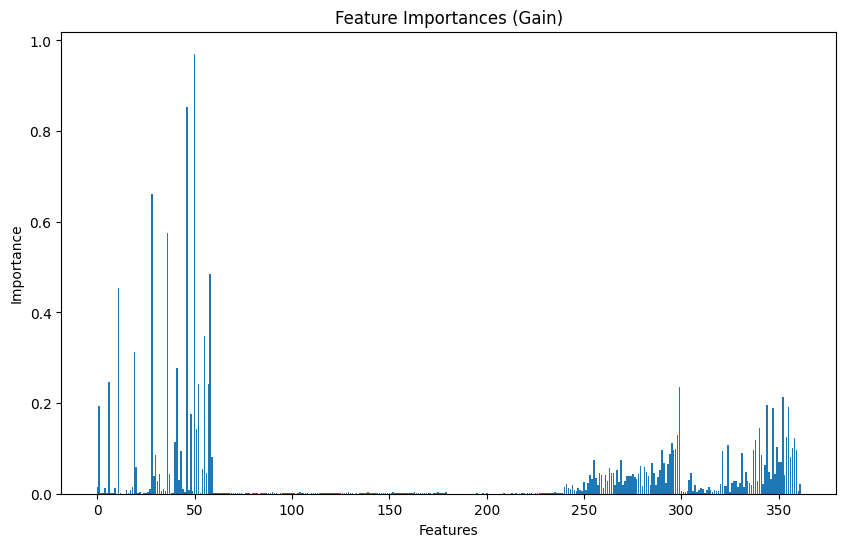

In [13]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(gain_importance)), gain_importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Gain)')
plt.show()



In [14]:
df = pd.DataFrame({'Feature': colnames, 'Importance': abs(gain_importance)})
df = df.sort_values(by='Importance', ascending=False)

In [15]:
sum_dict = {}

# Loop through dataframe to populate sum_dict
for index, row in df.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    initial_chars = feature[:5]
    if initial_chars not in sum_dict:
        sum_dict[initial_chars] = importance
    else:
        sum_dict[initial_chars] += importance

# Renaming keys in sum_dict
sum_dict['ask1_bid1_spread'] = sum_dict.pop('ask1_')
sum_dict['wap2_log_high_low'] = sum_dict.pop('wap2_')
sum_dict['wap1_log_high_low'] = sum_dict.pop('wap1_')

# Sorting the summed dictionary
sorted_sumd = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)

# Separating keys and values for plotting
keys = [item[0] for item in sorted_sumd]
values = [item[1] for item in sorted_sumd]

In [16]:
values = [round(x / sum(values),3) for x in values]

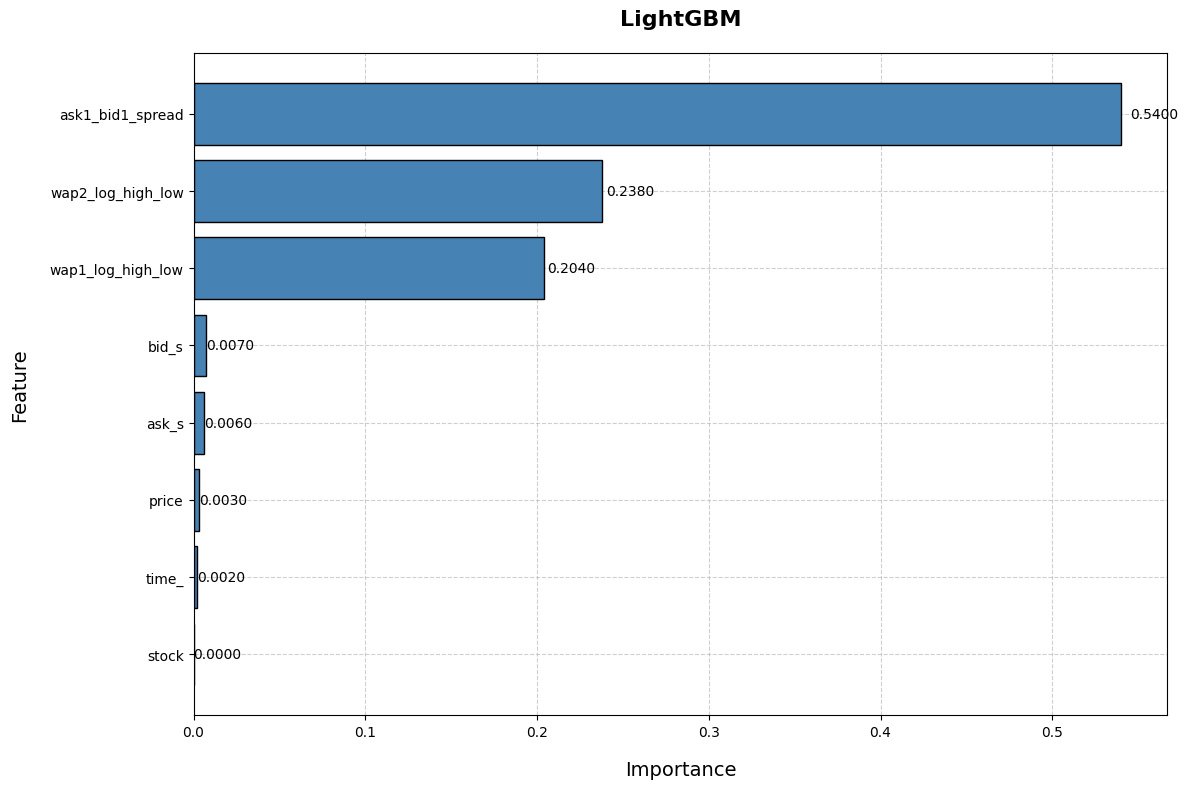

In [17]:
# Enhanced plotting function
def plot_feature_importances(values, keys):
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plotting
    bars = ax.barh(keys, values, color='steelblue', edgecolor='black')
    
    # Adding values on the bars
    for bar in bars:
        width = bar.get_width()
        ax.text(width * 1.01, bar.get_y() + bar.get_height() / 2, 
                f'{width:.4f}', ha='left', va='center')
    
    # Titles and labels
    ax.set_title('LightGBM', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Importance', fontsize=14, labelpad=15)
    ax.set_ylabel('Feature', fontsize=14, labelpad=15)
    
    # Inverting y-axis to have the highest importance on top
    ax.invert_yaxis()
    
    # Grid and styling
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_axisbelow(True)

    # Report text
    report_text = (
        "This report visualizes the aggregated importances of different features. "
        "Each feature's importance was summed up based on its initial characters, "
        "and the aggregated values were plotted to identify the most significant features."
    )
    plt.figtext(0.1, -0.1, "", wrap=True, horizontalalignment='left', fontsize=12)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Plot the feature importances
plot_feature_importances(values, keys)

# MLP

In [9]:
remove_price = True
if remove_price:
    train_data, val_data, test_data = remove_price_col(train, val, test)
else:
    train_data = train
    val_data = val
    test_data = test

In [10]:
scaler = StandardScaler()
torch_tensor=True
X_train, y_train = createX_and_y(train_data,scaler,torch_tensor)
X_val, y_val = createX_and_y(val_data,scaler,torch_tensor)
X_test, y_test = createX_and_y(test_data,scaler,torch_tensor)


In [11]:
colnames  = train_data.drop(columns='target').columns

In [12]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [13]:
dropout_prob=0.1
class NN2(nn.Module):
    def __init__(self):
        super(NN2, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(X_train.shape[1], 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_prob),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_prob),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(dropout_prob),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)

In [14]:
model = NN2().to(device)
criterion = rmspe_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 30
for epoch in range(epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(targets, outputs.squeeze())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    avg_train_loss = np.mean(train_losses)
    
    model.eval()
    with torch.no_grad():
        train_predictions = model(X_train).squeeze()
        print(torch.mean(train_predictions))
        train_rmspe = rmspe_loss(y_train, train_predictions).item()
    
    with torch.no_grad():
        val_predictions = model(X_val).squeeze()
        print(torch.mean(val_predictions))
        val_loss = criterion(y_val, val_predictions).item()
        val_rmspe = val_loss  # Since val_loss is already RMSPE
    
    # Step the scheduler
    scheduler.step()
    
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.9f}, Train RMSPE: {train_rmspe:.4f}, Val Loss: {val_loss:.9f}, Val RMSPE: {val_rmspe:.4f}')

tensor(0.0026)
tensor(0.0026)
Epoch 1, Train Loss: 8.794871055, Train RMSPE: 0.4321, Val Loss: 0.431053758, Val RMSPE: 0.4311
tensor(0.0039)
tensor(0.0039)
Epoch 2, Train Loss: 0.601351495, Train RMSPE: 0.4356, Val Loss: 0.434032708, Val RMSPE: 0.4340
tensor(0.0041)
tensor(0.0041)
Epoch 3, Train Loss: 0.489785745, Train RMSPE: 0.4248, Val Loss: 0.420775503, Val RMSPE: 0.4208
tensor(0.0045)
tensor(0.0045)
Epoch 4, Train Loss: 0.442733798, Train RMSPE: 0.7165, Val Loss: 0.711852551, Val RMSPE: 0.7119
tensor(0.0032)
tensor(0.0032)
Epoch 5, Train Loss: 0.368293392, Train RMSPE: 0.2766, Val Loss: 0.277163178, Val RMSPE: 0.2772
tensor(0.0032)
tensor(0.0032)
Epoch 6, Train Loss: 0.309081212, Train RMSPE: 0.2950, Val Loss: 0.290633917, Val RMSPE: 0.2906
tensor(0.0036)
tensor(0.0036)
Epoch 7, Train Loss: 0.290939307, Train RMSPE: 0.3092, Val Loss: 0.303875059, Val RMSPE: 0.3039
tensor(0.0034)
tensor(0.0034)
Epoch 8, Train Loss: 0.280056135, Train RMSPE: 0.2456, Val Loss: 0.247062176, Val RMSPE:

In [15]:
# Put the model in evaluation mode
model.eval()

# Disable gradient calculation for evaluation
with torch.no_grad():
    val_predictions = model(X_val).squeeze()
    rmspe_val = criterion(y_val, val_predictions).item()
    r_squared_val = calculate_r_squared(y_val, val_predictions)

    test_predictions = model(X_test).squeeze()
    rmspe_test = criterion(y_test, test_predictions).item()
    r_squared_test = calculate_r_squared(y_test, test_predictions)

    print(f"Validation RMSPE: {rmspe_val}")
    print(f"Validation R-squared: {r_squared_val}")
    print(f"Test RMSPE: {rmspe_test}")
    print(f"Test R-squared: {r_squared_test}")

Validation RMSPE: 0.2403782159090042
Validation R-squared: 0.7518689632415771
Test RMSPE: 0.23716266453266144
Test R-squared: 0.7417435050010681


In [16]:
importances = permutation_importance_NN(model, X_test, y_test, rmspe)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

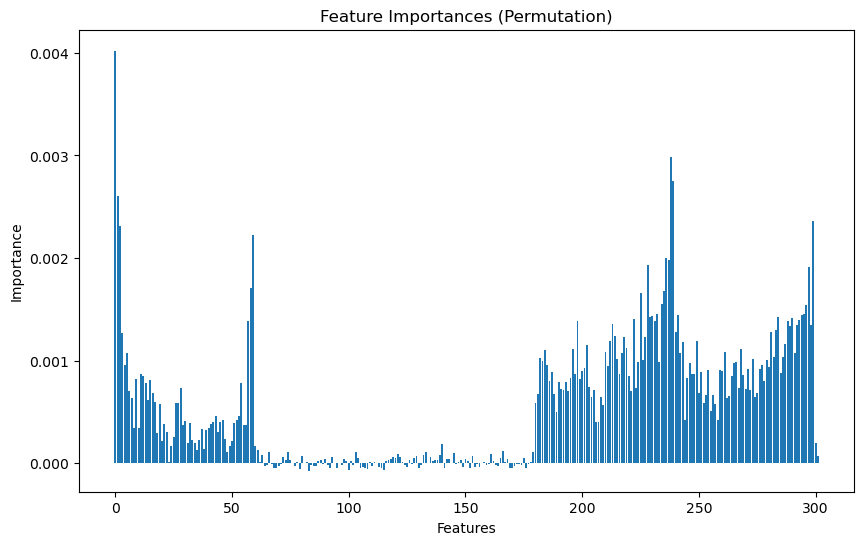

In [17]:
# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances (Permutation)')
plt.show()

In [18]:
df = pd.DataFrame({'Feature': colnames, 'Importance': abs(importances)})
df = df.sort_values(by='Importance', ascending=False)

In [19]:
sum_dict = {}

# Loop through dataframe to populate sum_dict
for index, row in df.iterrows():
    feature = row['Feature']
    importance = row['Importance']
    initial_chars = feature[:5]
    if initial_chars not in sum_dict:
        sum_dict[initial_chars] = importance
    else:
        sum_dict[initial_chars] += importance

# Renaming keys in sum_dict
sum_dict['ask1_bid1_spread'] = sum_dict.pop('ask1_')
sum_dict['wap2_log_high_low'] = sum_dict.pop('wap2_')
sum_dict['wap1_log_high_low'] = sum_dict.pop('wap1_')

# Sorting the summed dictionary
sorted_sumd = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)

# Separating keys and values for plotting
keys = [item[0] for item in sorted_sumd]
values = [item[1] for item in sorted_sumd]

In [20]:
values = [round(x / sum(values),3) for x in values]

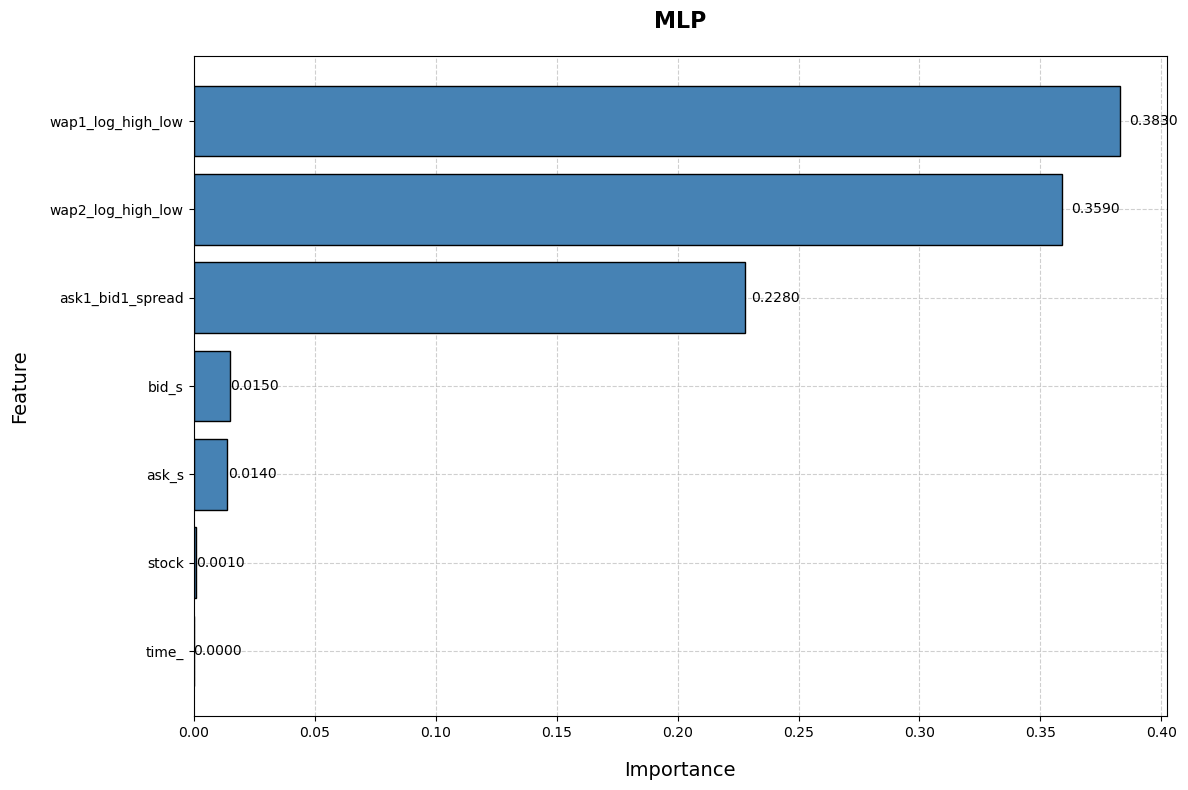

In [21]:
# Plot the feature importances
plot_feature_importances(values, keys, 'MLP')